In [1]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
from isr.metrics import Metrics
from skimage.restoration import (
    denoise_bilateral,
    denoise_wavelet,
    denoise_tv_chambolle,
    denoise_nl_means,
)

In [2]:
metrics = Metrics()
metrics.generate_metric_report(list_of_hr_images=[], list_of_predictions=[])

{'mse': [], 'ssim': []}

In [3]:
lr_images = [
    cv2.imread(f, cv2.IMREAD_COLOR) for f in sorted(glob("./data/SuperResolution/LR/*"))
]

hr_images = [
    cv2.imread(f, cv2.IMREAD_COLOR) for f in sorted(glob("./data/SuperResolution/HR/*"))
]

In [4]:
def get_denoised_images(image):
    method2output = {}
    method2output["Bilateral"] = cv2.bilateralFilter(image, 9, 75, 75)
    method2output["Gaussian"] = cv2.GaussianBlur(image, (5, 5), 0)
    method2output["Median"] = cv2.medianBlur(image, 5)
    method2output["Non-Local Means"] = cv2.fastNlMeansDenoisingColored(
        image, None, 10, 10, 7, 21
    )
    return method2output

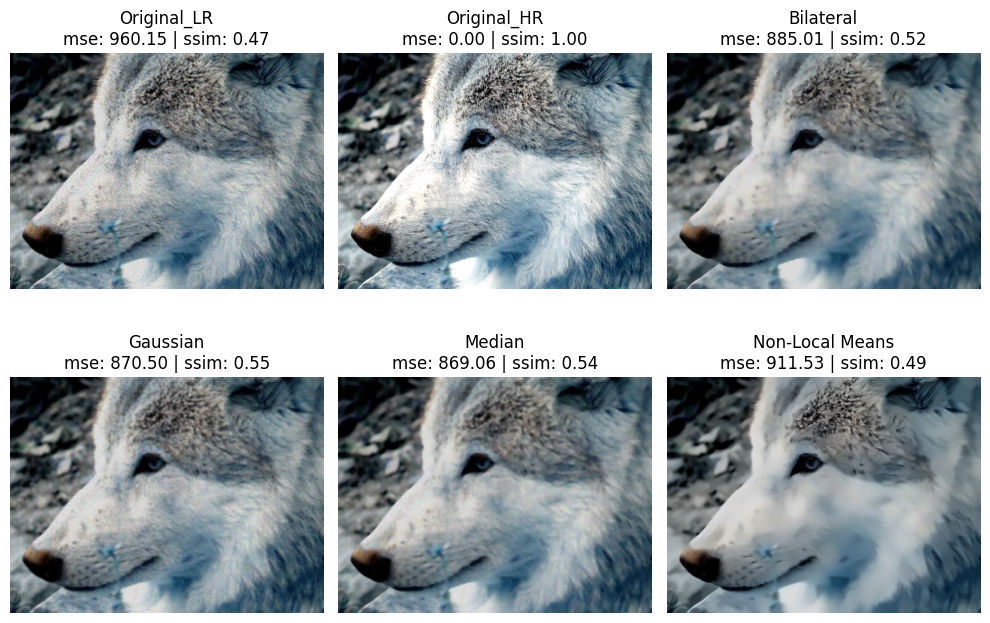

In [5]:
def denoise_and_plot_using_cv2(lr_image, hr_image):
    method2output = get_denoised_images(lr_image)
    plt.rcParams["figure.figsize"] = (10, 7)
    method2output = {"Original_LR": lr_image, "Original_HR": hr_image, **method2output}
    fig, axs = plt.subplots(2, (len(method2output) + 1) // 2)
    axs = axs.ravel()
    for i, (method, output) in enumerate(method2output.items()):
        axs[i].imshow(output)
        axs[i].axis("off")
        metric_report = metrics.generate_metric_report(
            list_of_hr_images=[
                cv2.resize(hr_image, (output.shape[1], output.shape[0]))
            ],
            list_of_predictions=[output],
        )
        axs[i].set_title(
            f"{method}\nmse: {metric_report['mse'][0]:.2f} | ssim: {metric_report['ssim'][0]:.2f}"
        )
    plt.tight_layout()
    plt.show()


denoise_and_plot_using_cv2(lr_images[4], hr_images[4])

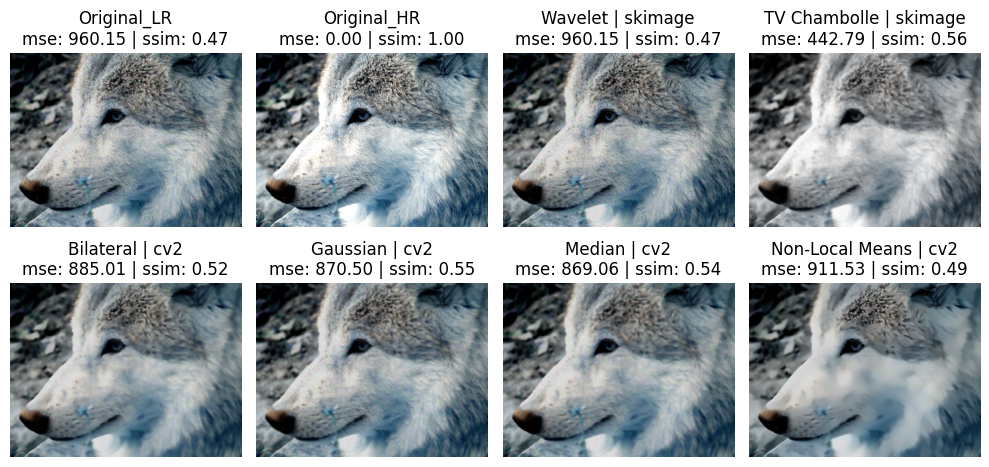

In [10]:
def denormalize(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)


def denoise_and_plot_using_skimage(lr_image, hr_image):
    method2output = {}
    denoised_wavelet_image = denoise_wavelet(lr_image)
    denoised_wavelet_image = denormalize(denoised_wavelet_image)
    method2output["Wavelet | skimage"] = denoised_wavelet_image
    denoised_tv_chambolle_image = denoise_tv_chambolle(lr_image, weight=0.1)
    denoised_tv_chambolle_image = denormalize(denoised_tv_chambolle_image)
    method2output["TV Chambolle | skimage"] = denoised_tv_chambolle_image

    cv2_denoised_images = get_denoised_images(lr_image)
    for method, output in cv2_denoised_images.items():
        method2output[f"{method} | cv2"] = output
    plt.rcParams["figure.figsize"] = (10, 5)
    method2output = {"Original_LR": lr_image, "Original_HR": hr_image, **method2output}
    fig, axs = plt.subplots(2, (len(method2output) + 1) // 2)
    axs = axs.ravel()
    for i, (method, output) in enumerate(method2output.items()):
        axs[i].imshow(output)
        axs[i].axis("off")
        metric_report = metrics.generate_metric_report(
            list_of_hr_images=[
                cv2.resize(hr_image, (output.shape[1], output.shape[0]))
            ],
            list_of_predictions=[output],
        )
        axs[i].set_title(
            f"{method}\nmse: {metric_report['mse'][0]:.2f} | ssim: {metric_report['ssim'][0]:.2f}"
        )
    plt.tight_layout()
    plt.show()


denoise_and_plot_using_skimage(lr_images[4], hr_images[4])